## Homework_2023_04_24 图像处理进阶  
教师：胡俊峰

助教：谷东润 陈福康

本次作业总分为10分，涉及代码题干有明确提示，部分可参考ppt，多为调参任务，只需要了解如何调用函数，结果较为直观，难度较低，希望各位顺利度过期中。

#### 0 导入相关包以及图片

In [186]:
import os
os.environ["OMP_NUM_THREADS"] = '1'
from skimage import io
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import cv2

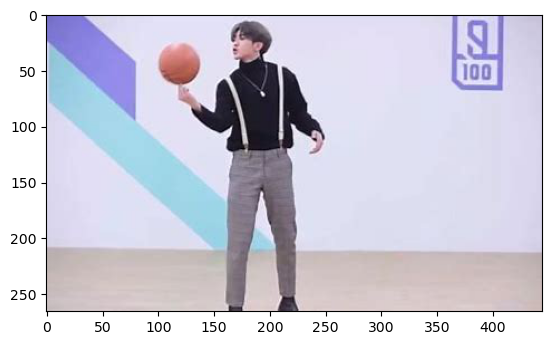

In [187]:
img=cv2.imread('OIP.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

## 第零部分，请认真阅读代码，理解代码的功能

#### 0.1 人脸识别，根据在两张图上的效果，思考该算法的局限性。

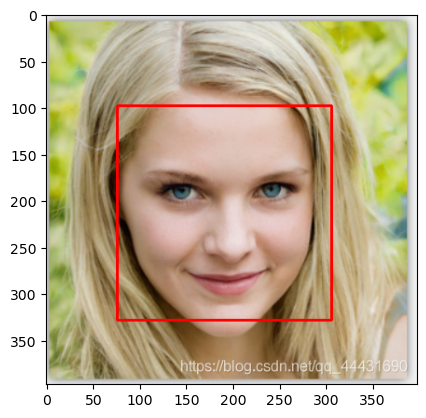

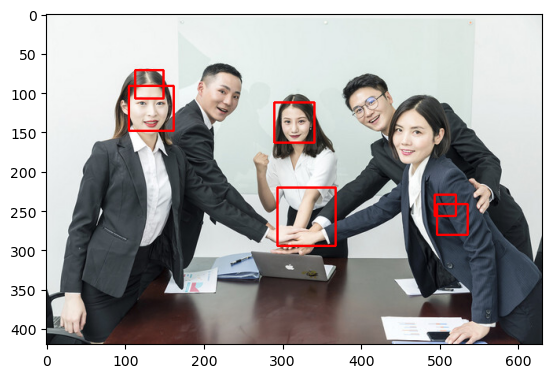

In [188]:
def face_detect_demo(img):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # gray = cv2.equalizeHist(gray)
    face_detector = cv2.CascadeClassifier('./haarcascade_frontalcatface.xml')
    faces = face_detector.detectMultiScale(gray,1.01,1)
    img = img.copy()
    for x,y,w,h in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    return img
img = cv2.cvtColor(cv2.imread('./girl.png'),cv2.COLOR_BGR2RGB)
plt.imshow(face_detect_demo(img))
plt.show()

img = cv2.cvtColor(cv2.imread('./team.jpg'),cv2.COLOR_BGR2RGB)
plt.imshow(face_detect_demo(img))
plt.show()

#### 0.2 HSV分解
参考链接：[rgb与hsv的转化](https://docs.opencv.org/3.4/de/d25/imgproc_color_conversions.html#color_convert_rgb_hsv)

In [189]:
img=cv2.imread('OIP.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
hsv=cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
H,S,V=cv2.split(hsv)

113.48287233753409


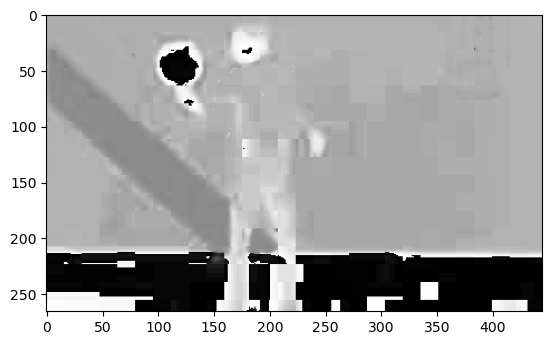

In [190]:
## 色调（H）
h = H.ravel()[np.flatnonzero(H)]
average_h  = sum(h)/len(h)
plt.imshow(H,cmap = 'gray')
print(average_h)

32.87914167441075


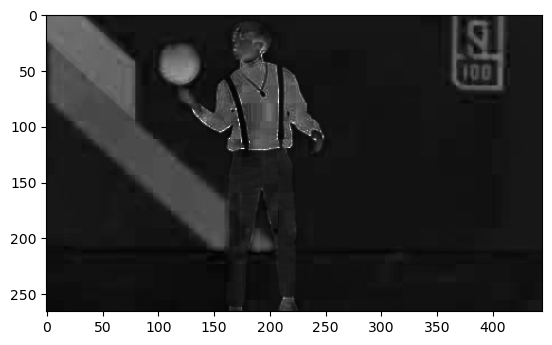

In [191]:
## 饱和度（S）
s = S.ravel()[np.flatnonzero(S)]
average_s  = sum(s)/len(s)
plt.imshow(S,cmap = 'gray')
print(average_s)

216.29651938835855


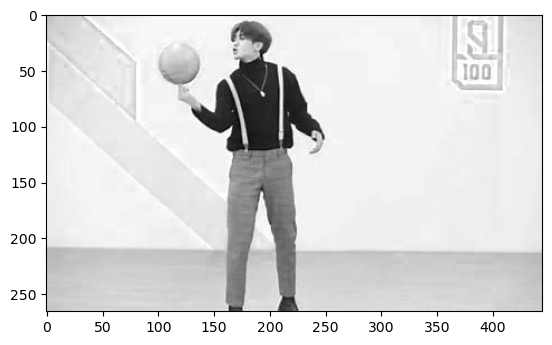

In [192]:
## 明度（V）
v = V.ravel()[np.flatnonzero(V)]   
average_v  = sum(v)/len(v)
plt.imshow(V,cmap = 'gray')
print(average_v)

## 第一部分：图像处理

本部分以实现要求功能为主。

#### 1.1 通过聚类，提取图像的主色

预处理，将原图片的像素排成一列

In [193]:
img_ori_shape = img.shape
img_flat = img.reshape((img_ori_shape[0] * img_ori_shape[1], img_ori_shape[2]))
img_shape = img_flat.shape
n_channels = img_shape[1]
print(img_ori_shape)
print(img_shape)

(266, 445, 3)
(118370, 3)


利用KMeans函数，构造一个命名为estimator的聚类器，设置聚类中心数为5、最大迭代次数为4000、init参数（即初始化策略）选择效果较好的'k-means++',使用给定的随机种子进行聚类，绘制将原图像素值设置为对应聚类中心点像素值后得到的新图像。(注意数据类型)
（2分）

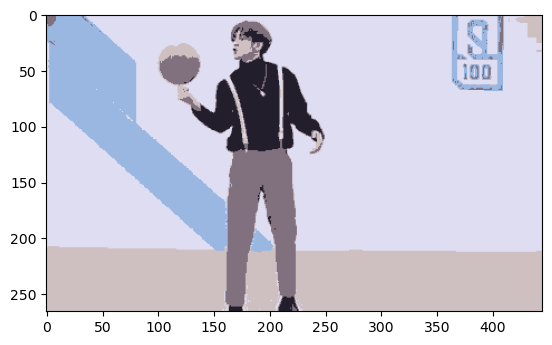

In [194]:
random_state=42
k=5
#TODO
estimator=KMeans(n_clusters=k,max_iter=4000,init='k-means++',random_state=random_state,n_init=50)
estimator.fit(img_flat)
centroids=estimator.cluster_centers_
new_img_data=np.zeros_like(img_flat)
for i in range(k):
    new_img_data[np.where(estimator.labels_==i)]=centroids[i]
new_img_data=new_img_data.reshape(img_ori_shape)
plt.imshow(new_img_data)
plt.show()

以5个聚类中心的值作为像素值，将这5个颜色排成一列展示出来，并在合适位置标注每个聚类的数量(2分)

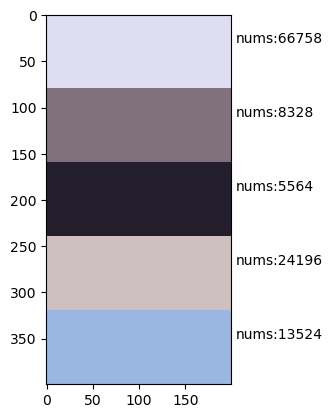

In [195]:
result_width = 200               #每个颜色块的宽度
result_height_per_center = 80    #每个颜色块的长度
#TODO
result=[]
for i in range(k):
    result.append(np.full((result_width*result_height_per_center,n_channels),centroids[i],dtype=int))
    count=np.sum(estimator.labels_==i)
    plt.text(205,i*80+30,'nums:'+str(count))
result=np.array(result)
result=result.reshape((result_height_per_center*k,result_width,n_channels))
plt.imshow(result)
plt.show()


#### 1.2 前景背景分割
在本部分中你需要将图片中的前景提取出来，并把背景部分换成你喜欢的图片。

调用grabCut，设置正确的参数值，提取出符合直觉的较为完整的前景（注意：不必与参考输出完全一致，但应尽可能地保留前景细节） （2分）

请参考链接[grabcut](https://docs.opencv.org/3.4/d8/d83/tutorial_py_grabcut.html)了解该函数的用法，链接中已经包含<font color='red'>示例代码</font>，你需要做的只是理解各个参数的含义，然后调试rect的值以达到较好的分割效果。

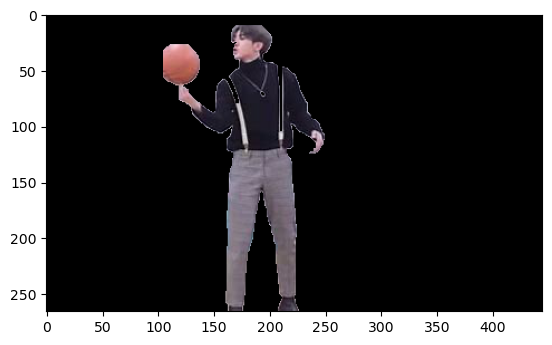

In [196]:
#TODO
# 创建与原图大小一致的掩膜
mask = np.zeros(img.shape[:2], np.uint8)

# 定义背景模型和前景模型
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

# 定义需要处理的矩形区域
rect = (105, 10, 200, 300)

# 进行grabCut
cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

# 提取前景
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img_fg = img*mask2[:,:,np.newaxis]
# 显示结果
plt.imshow(img_fg)
plt.show()


将另一张图片作为背景（你也可以使用你自己喜欢的图片作为背景），将前面提取出的前景放入该背景中，实现背景替换(要使用向量化操作)（2分）

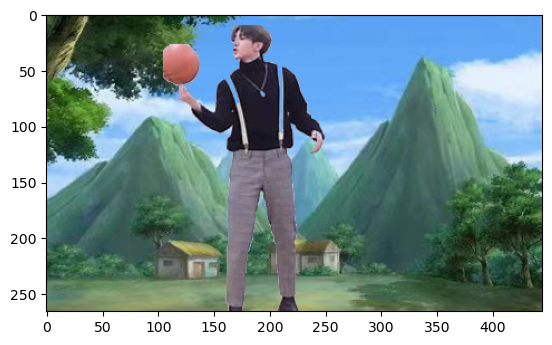

In [197]:
back=cv2.cvtColor(cv2.imread('back.jpg'),cv2.COLOR_BGR2RGB)
back=cv2.resize(back,(img.shape[1],img.shape[0]))
#TODO
img_bg=back*(1-mask2[:,:,np.newaxis])
final=img_fg+img_bg
plt.imshow(final)
plt.show()

## 1.3 Hough变换(2分)
Hough变换可以用于检测一些简单的几何图形如直线、圆形等，相应的原理可以参考ppt和[hough变换算法](https://www.cnblogs.com/pingwen/p/12506240.html)，一般的步骤是通过边缘检测算子提取灰度图的图像边缘，然后在边缘图像上进行hough变换提取相应几何图形.

这里我们读取一张道路的图片，其中包含较多的噪点，直接提取边缘的效果不佳，你可以采用任意一种opencv自带的blur方法对其进行降噪，以获得更符合预期的边缘，然后使用Canny算子获取边缘，运用Hough变换(调用`cv2.HoughLines`)识别出主要的直线，如地平线、道路线。所有kernel边长为3即可，你需要调整可能用到的函数参数，以获得较好的效果。

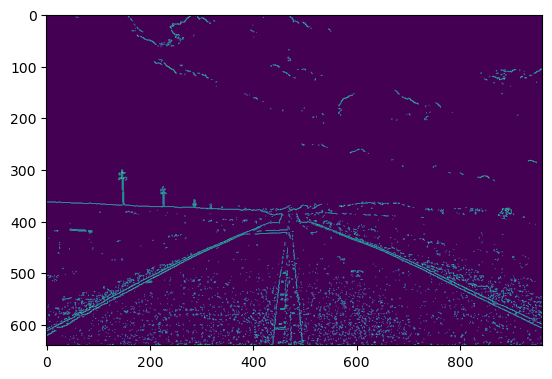

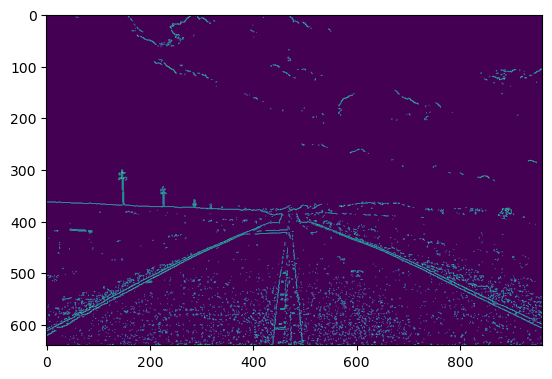

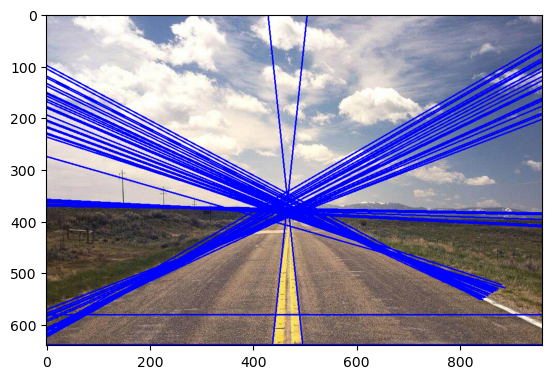

In [198]:
road_img=cv2.imread('road.jpg')
road_img = cv2.cvtColor(road_img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(road_img, cv2.COLOR_RGB2GRAY)


# 对图像进行高斯滤波以降噪
gray_blur = cv2.GaussianBlur(gray, (3, 3), 0)
edges = cv2.Canny(gray, 270, 300,apertureSize = 3) #这里的阈值参数与降噪后的参数并不一定一致，仅用于展示噪点。
plt.imshow(edges)
plt.show()
#TODO
# Hough变换识别直线
lines = cv2.HoughLines(edges, rho=1, theta=np.pi/180, threshold=85)
new_img = road_img.copy()
# 画线（假设hough变换返回了lines集合）
if lines is not None:
    for line in lines:
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = rho * a
        y0 = rho * b
        # k1*k2=-1 ==> k2=-1/k1
        # k1 = tan(θ) ==> k2 = -1/tan(θ)=-cot(θ)
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * a)
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * a)
        cv2.line(new_img,(x1,y1),(x2,y2),(0,0,255),2)
plt.imshow(edges)
plt.show()
plt.imshow(new_img)
plt.show()